In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from scipy import stats

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import datasets, metrics

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "heartdisease"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

heart_df = pd.read_sql_query("select * from heartdisease", con=engine)

engine.dispose()

<IPython.core.display.Javascript object>

In [4]:
heart_df = heart_df.drop(index=0, axis=0)
# Define the features and the outcome
X = heart_df.iloc[:, :13]
y = heart_df.iloc[:, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace="?", value=0)

# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 1, 0)

<IPython.core.display.Javascript object>

In [5]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0


<IPython.core.display.Javascript object>

In [6]:
column_rename_map = {
    "0": "age",
    "1": "sex",
    "2": "cp",
    "3": "trestbps",
    "4": "chol",
    "5": "fbs",
    "6": "restecg",
    "7": "thalach",
    "8": "exang",
    "9": "oldpeak",
    "10": "slope",
    "11": "ca",
    "12": "thal",
}

X = X.rename(columns=column_rename_map)
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0


<IPython.core.display.Javascript object>

In [7]:
cat_cols = ["age", "sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
X_num = X.drop(columns=cat_cols)
X_num

,trestbps,chol,thalach,oldpeak
1,160.0,286.0,108.0,1.5
2,120.0,229.0,129.0,2.6
3,130.0,250.0,187.0,3.5
4,130.0,204.0,172.0,1.4
5,120.0,236.0,178.0,0.8
...,...,...,...,...
298,110.0,264.0,132.0,1.2
299,144.0,193.0,141.0,3.4
300,130.0,131.0,115.0,1.2
301,130.0,236.0,174.0,0.0


<IPython.core.display.Javascript object>

In [8]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_num)
X_std = pd.DataFrame(X_std)
X_std

,0,1,2,3
0,1.612596,0.758372,-1.818840,0.400906
1,-0.662326,-0.342633,-0.900807,1.350164
2,-0.093596,0.063000,1.634713,2.126829
3,-0.093596,-0.825530,0.978975,0.314610
4,-0.662326,-0.207422,1.241270,-0.203167
...,...,...,...,...
297,-1.231057,0.333423,-0.769660,0.142017
298,0.702627,-1.038004,-0.376217,2.040533
299,-0.093596,-2.235588,-1.512829,0.142017
300,-0.093596,-0.207422,1.066406,-0.893537


<IPython.core.display.Javascript object>

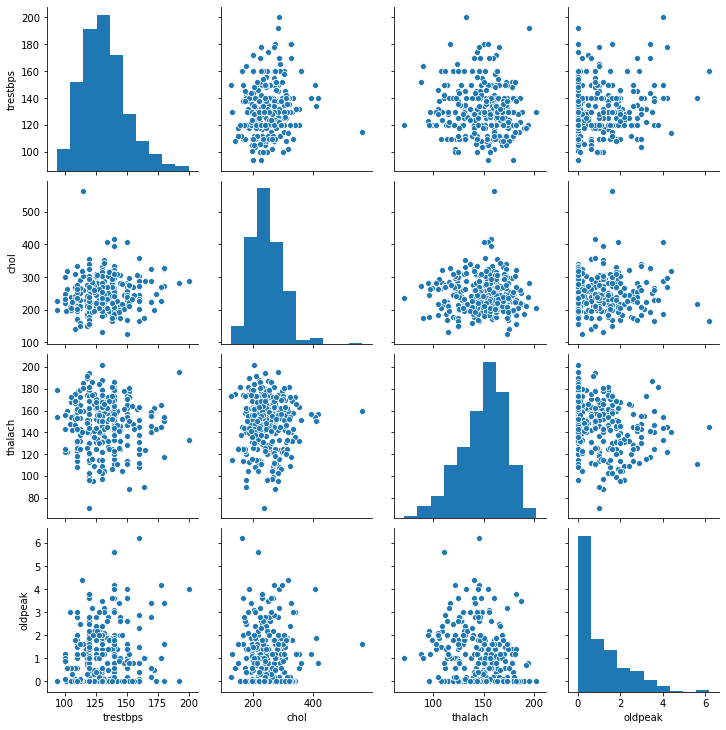

<IPython.core.display.Javascript object>

In [9]:
sns.pairplot(X_num)

1. Apply GMM to the heart disease dataset by setting n_components=2. Get ARI and silhouette scores for your solution and compare it with those of the k-means and hierarchical clustering solutions that you implemented in the previous checkpoint assignments. Which algorithm performs best?

In [10]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X_std)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

<IPython.core.display.Javascript object>

In [11]:
pd.DataFrame(scaler.inverse_transform(gmm.means_)).style.background_gradient()

,0,1,2,3
0,129.215525,242.733596,162.110321,0.000000
1,132.828990,248.688429,143.517354,1.539601


<IPython.core.display.Javascript object>

In [12]:
gmm_probs = pd.DataFrame(gmm.predict_proba(X_std))

<IPython.core.display.Javascript object>

In [13]:
gmm_probs

,0,1
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
...,...,...
297,0.000000,1.000000
298,0.000000,1.000000
299,0.000000,1.000000
300,0.999664,0.000336


<IPython.core.display.Javascript object>

In [14]:
print(gmm_probs[1].value_counts())
print(y.sum())

1.000000    203
0.000360      1
0.000575      1
0.000766      1
0.000462      1
           ... 
0.000507      1
0.000479      1
0.002603      1
0.000694      1
0.000866      1
Name: 1, Length: 100, dtype: int64
139


<IPython.core.display.Javascript object>

In [15]:
labels = gmm.predict(X_std)
X["labels"] = labels

<IPython.core.display.Javascript object>

In [16]:
labels.sum()

203

<IPython.core.display.Javascript object>

In [17]:
print(f"The ARI is {metrics.adjusted_rand_score(y, labels)}")
print(
    f"The Silhouette Score is {metrics.silhouette_score(X_std, labels, metric='euclidean')}"
)

The ARI is 0.05025082907569892
The Silhouette Score is 0.10949219341309024


<IPython.core.display.Javascript object>

In [18]:
gmm_probs[0].value_counts()

0.000000    203
0.991104      1
0.974982      1
0.999656      1
0.999690      1
           ... 
0.999440      1
0.999560      1
0.999631      1
0.999672      1
0.999267      1
Name: 0, Length: 100, dtype: int64

<IPython.core.display.Javascript object>

Strange that the the predictions are at 100% confidence. Is this data linearly separable?

2. GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. There are four types that you can specify:

    * full: This is the default. Each component has its own general covariance matrix.
    * tied: All components share the same general covariance matrix.
    * diag: Each component has its own diagonal covariance matrix.
    * spherical: Each component has its own single variance.

Try all of these. Which one performs best in terms of ARI and silhouette scores?

In [19]:
covars = ["full", "tied", "diag", "spherical"]
for covar in covars:

    gmm = GaussianMixture(n_components=2, covariance_type=covar)
    clusters = gmm.fit_predict(X_std)

    print("Covariance Type: " + covar)
    print(f"The ARI is {metrics.adjusted_rand_score(y, clusters)}")
    print(
        f"The Silhouette Score is {metrics.silhouette_score(X_std, clusters, metric='euclidean')}"
    )
    print("-----")



Covariance Type: full
The ARI is 0.05025082907569892
The Silhouette Score is 0.10949219341309024
-----
Covariance Type: tied
The ARI is 0.20583168492456116
The Silhouette Score is 0.2770479207206773
-----
Covariance Type: diag
The ARI is 0.05025082907569892
The Silhouette Score is 0.10949219341309024
-----
Covariance Type: spherical
The ARI is 0.1550930667675427
The Silhouette Score is 0.23360784061771267
-----


<IPython.core.display.Javascript object>